# 02_humidity_in_vegetation

## Import libraries

In [1]:
import os
import sys

import pandas as pd
import geopandas as gpd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns

from pandas.api.types import CategoricalDtype

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join('../../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

In [34]:
# Save results locally?
local_save_dir = '../../../data/processed/projects/26_alvaro_obregon/'
local_save = False

## Set area of interest (aoi)

In [2]:
city = 'CDMX'

## 1. Load NDVI res 10 and find places with vegetation by alcaldía

In [4]:
# Downloading NDVI res 10 data (aprox. 150-200s)
ndvi_schema = 'raster_analysis'
ndvi_table = 'ndvi_analysis_hex'
res = 10
query = f"SELECT * FROM {ndvi_schema}.{ndvi_table} WHERE \"city\" LIKE \'{city}\' AND \"res\" = {res}"
ndvi_res10 = aup.gdf_from_query(query, geometry_col='geometry')

# Shorten data
ndvi_res10 = ndvi_res10[['hex_id','ndvi_median']]

# Show
print(ndvi_res10.shape)
ndvi_res10.head(2)

(59557, 2)


,hex_id,ndvi_median
0,8a4995b8cb57fff,0.108460
1,8a4995b31c8ffff,0.548321


### NDVI Data treatment - Create vegetation categories

In [5]:
# Create vegetation categories
ndvi_res10['ndvi_median_rango'] = np.nan
ndvi_res10.loc[ndvi_res10.ndvi_median>=0.6 , 'ndvi_median_rango'] = 'Alta densidad vegetal'
ndvi_res10.loc[(ndvi_res10.ndvi_median>=0.4 )&
                (ndvi_res10.ndvi_median<0.6), 'ndvi_median_rango'] = 'Moderada densidad vegetal'
ndvi_res10.loc[(ndvi_res10.ndvi_median>=0.2)&
                (ndvi_res10.ndvi_median<0.4), 'ndvi_median_rango'] = 'Mínima densidad vegetal'
ndvi_res10.loc[(ndvi_res10.ndvi_median>=0.1)&
                (ndvi_res10.ndvi_median<0.2), 'ndvi_median_rango'] = 'Suelo'
ndvi_res10.loc[(ndvi_res10.ndvi_median<0.1), 'ndvi_median_rango'] = 'Suelo artificial/Agua/Piedra'

# Ordering data
categories = ['Suelo artificial/Agua/Piedra', 'Suelo', 'Mínima densidad vegetal', 'Moderada densidad vegetal', 'Alta densidad vegetal']
ndvi_res10['ndvi_median_rango'] = pd.Categorical(ndvi_res10['ndvi_median_rango'], categories=categories, ordered=True)

# Show
print(ndvi_res10.shape)
ndvi_res10.head(2)

(59557, 3)


,hex_id,ndvi_median,ndvi_median_rango
0,8a4995b8cb57fff,0.108460,Suelo
1,8a4995b31c8ffff,0.548321,Moderada densidad vegetal


### NDVI Data treatment - Filter for places with vegetation

In [6]:
#Keeping High-moderate-minimal vegetation density
data_withveg = ndvi_res10.loc[(ndvi_res10.ndvi_median_rango == 'Alta densidad vegetal') |
               (ndvi_res10.ndvi_median_rango == 'Moderada densidad vegetal')|
               (ndvi_res10.ndvi_median_rango == 'Mínima densidad vegetal')].copy()

# Show
print(data_withveg.shape)
data_withveg.head(2)

(35317, 3)


,hex_id,ndvi_median,ndvi_median_rango
1,8a4995b31c8ffff,0.548321,Moderada densidad vegetal
2,8a4995b22537fff,0.723297,Alta densidad vegetal


### hex_gdf Load data - (Has alcaldías)

In [12]:
# Download hex_gdf  (aprox. 150-200s)
hex_schema = 'hexgrid'
hex_table = 'hexgrid_10_city_2020'
query = f"SELECT * FROM {hex_schema}.{hex_table} WHERE \"city\" LIKE \'{city}\'"
hex_gdf = aup.gdf_from_query(query, geometry_col='geometry')

# Shorten data
hex_gdf_f = hex_gdf[['hex_id_10','NOMGEO','geometry']]
hex_gdf_f.rename(columns={'hex_id_10':'hex_id'},inplace=True)
del hex_gdf

# Show
print(hex_gdf_f.shape)
hex_gdf_f.head(2)

(86349, 3)


/tmp/ipykernel_67619/3851470774.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hex_gdf_f.rename(columns={'hex_id_10':'hex_id'},inplace=True)


,hex_id,NOMGEO,geometry
0,8a4995b8cb57fff,Azcapotzalco,"POLYGON ((-99.19358 19.48193, -99.19293 19.482..."
1,8a4995b88d67fff,Azcapotzalco,"POLYGON ((-99.17778 19.49754, -99.17713 19.497..."


### Data with veg (NDVI) + alcaldías (hex_gdf)

In [13]:
# Inner join to keep data with veg of alcaldías of interest only
data_withveg_alcaldias = data_withveg.merge(hex_gdf_f,on='hex_id',how='inner')

# Show
print(data_withveg_alcaldias.shape)
data_withveg_alcaldias.head(2)

(35317, 5)


,hex_id,ndvi_median,ndvi_median_rango,NOMGEO,geometry
0,8a4995b31c8ffff,0.548321,Moderada densidad vegetal,Cuajimalpa de Morelos,"POLYGON ((-99.27862 19.34681, -99.27797 19.347..."
1,8a4995b22537fff,0.723297,Alta densidad vegetal,Cuajimalpa de Morelos,"POLYGON ((-99.29964 19.33854, -99.29899 19.338..."


## 2. Load NDMI, merge with previous data and save locally (For GIS Map)

In [14]:
# Downloading NDVI res 10 data (aprox. 150-200s)
ndmi_schema = 'raster_analysis'
ndmi_table = 'ndmi_analysis_hex'
res = 10
query = f"SELECT * FROM {ndmi_schema}.{ndmi_table} WHERE \"city\" LIKE \'{city}\' AND \"res\" = {res}"
ndmi_res10 = aup.gdf_from_query(query, geometry_col='geometry')

# Shorten data
#ndvi_res10 = ndvi_res10[['hex_id','ndvi_median']]

# Show
print(ndmi_res10.shape)
ndmi_res10.head(2)

(59557, 11)


,hex_id,geometry,res,ndmi_mean,ndmi_std,ndmi_median,ndmi_max,ndmi_min,ndmi_diff,ndmi_tend,city
0,8a4995b8cb57fff,"POLYGON ((-99.19358 19.48193, -99.19293 19.482...",10,-0.046380,0.009873,-0.045801,-0.027397,-0.065636,0.038238,0.001967,CDMX
1,8a4995b06487fff,"POLYGON ((-99.27065 19.37736, -99.27000 19.377...",10,0.028496,0.009566,0.030914,0.042891,0.004829,0.038063,0.000281,CDMX


In [23]:
# Merge data
ndmi_alcaldia_res10 = pd.merge(data_withveg_alcaldias[['hex_id','NOMGEO','geometry']],
                               ndmi_res10[['hex_id','ndmi_mean','ndmi_min','ndmi_max']],
                               on='hex_id')
# Set geometry
ndmi_alcaldia_res10 = gpd.GeoDataFrame(ndmi_alcaldia_res10, geometry='geometry', crs='EPSG:4326')

# Format - rename and reorder cols
ndmi_alcaldia_res10.rename(columns={'NOMGEO':'nomgeo'},inplace=True)
ndmi_alcaldia_res10 = ndmi_alcaldia_res10[['hex_id','nomgeo','ndmi_min','ndmi_mean','ndmi_max','geometry']]

# Show
print(ndmi_alcaldia_res10.shape)
ndmi_alcaldia_res10.head(2)

(35317, 6)


,hex_id,nomgeo,ndmi_min,ndmi_mean,ndmi_max,geometry
0,8a4995b31c8ffff,Cuajimalpa de Morelos,0.126940,0.140503,0.157290,"POLYGON ((-99.27862 19.34681, -99.27797 19.347..."
1,8a4995b22537fff,Cuajimalpa de Morelos,0.124771,0.165196,0.192658,"POLYGON ((-99.29964 19.33854, -99.29899 19.338..."


In [31]:
if local_save:
    ndmi_alcaldia_res10.to_file(local_save_dir+'ndmi_alcaldia_res10.gpkg')

## 3. Find average min, mean and max NDMI data by alcaldía

In [26]:
# Group by
grouped_by = ndmi_alcaldia_res10.groupby(['nomgeo']).agg({'ndmi_min':np.mean,
                                                         'ndmi_mean':np.mean,
                                                         'ndmi_max':np.max})
grouped_by.reset_index(inplace=True)

# Show
grouped_by

,nomgeo,ndmi_min,ndmi_mean,ndmi_max
0,Azcapotzalco,-0.006836,0.019625,0.180042
1,Benito Juárez,0.005369,0.023755,0.183055
2,Coyoacán,0.003527,0.034019,0.256732
3,Cuajimalpa de Morelos,0.060471,0.109743,0.273108
4,Cuauhtémoc,0.014984,0.031739,0.225798
5,Gustavo A. Madero,-0.058218,0.002128,0.269674
6,Iztacalco,-0.006538,0.018741,0.167474
7,Iztapalapa,-0.053382,-0.004349,0.281767
8,La Magdalena Contreras,0.044079,0.085891,0.323540
9,Miguel Hidalgo,0.014317,0.046695,0.316615


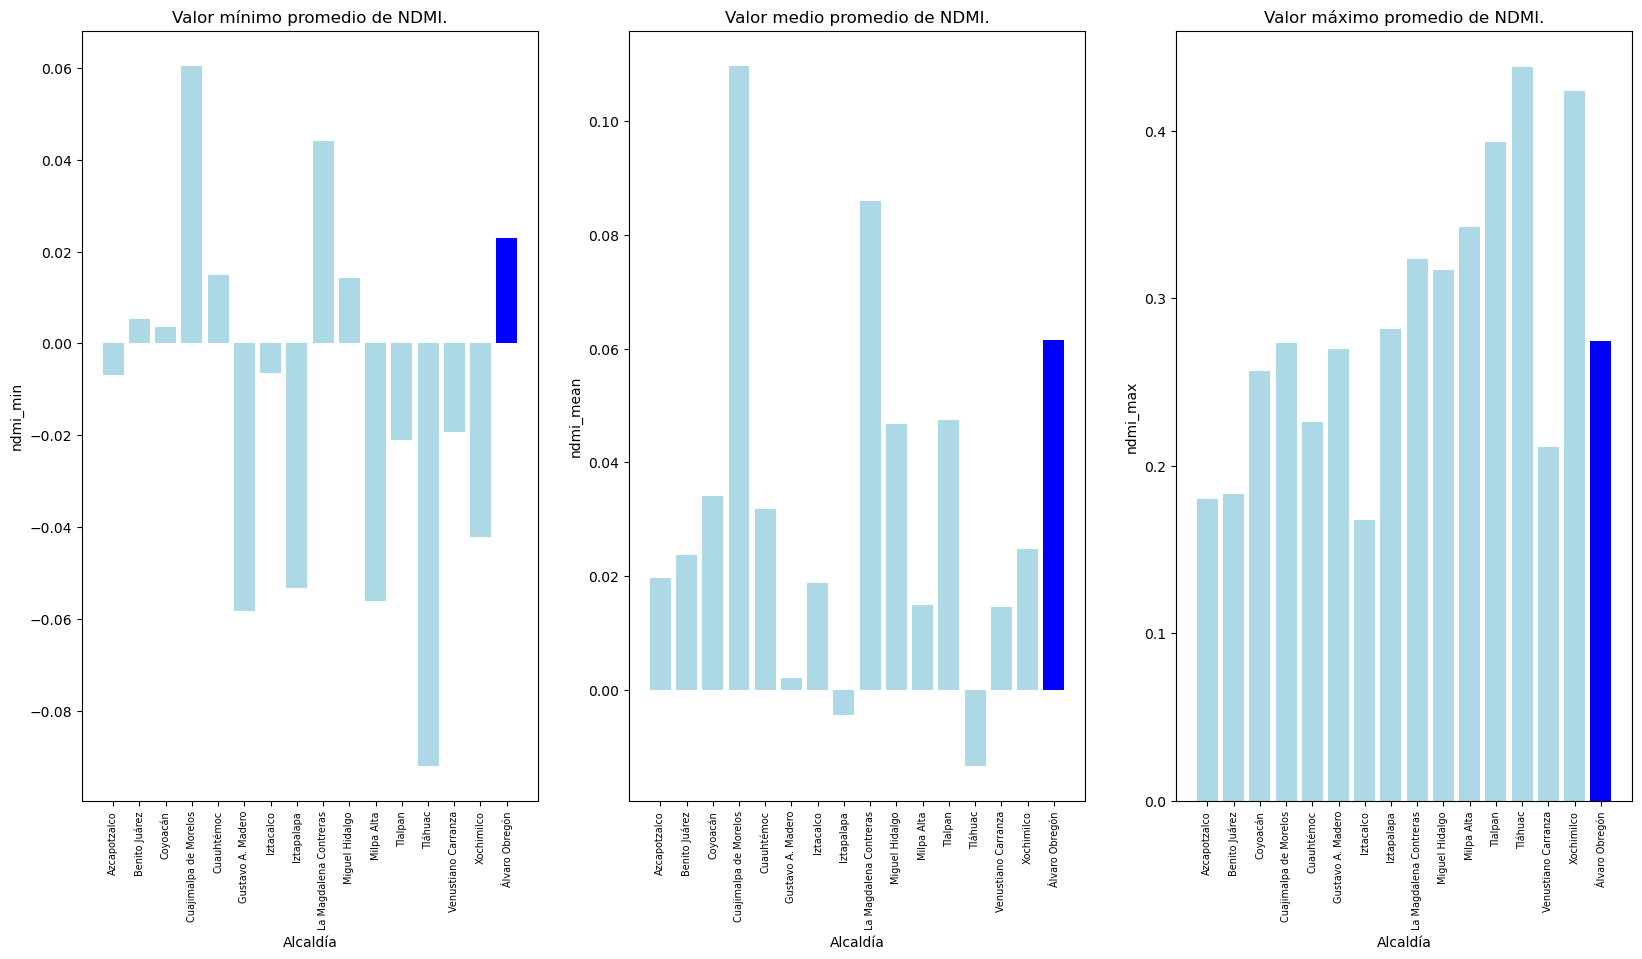

In [57]:
fig,axs = plt.subplots(1,3,figsize=(20,10))

comparisons_dict = {'mínimo':'ndmi_min',
                    'medio':'ndmi_mean',
                    'máximo':'ndmi_max'}

ax = 0
for comparison in comparisons_dict.keys():
    # Find data col for current comparison
    data_col = comparisons_dict[comparison]

    # Plot data
    colors = ['blue' if nom == 'Álvaro Obregón' else 'lightblue' for nom in grouped_by['nomgeo']]
    axs[ax].bar(grouped_by['nomgeo'],grouped_by[data_col], color=colors)
    
    # ---------- FORMAT ----------
    # Format - Titles
    axs[ax].set_title(f'Valor {comparison} promedio de NDMI.')
    axs[ax].set_xlabel('Alcaldía')
    axs[ax].set_ylabel(data_col)
    
    # Rotate ticks
    x = axs[ax].get_xaxis()
    for item in x.get_ticklabels():
        item.set_rotation(90)
        item.set_size(7)

    # Increment ax
    ax+=1           

In [97]:
alcaldias = list(grouped_by['nomgeo'].unique())
len_alcaldias = len(alcaldias)

/tmp/ipykernel_67619/3759514305.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=rotation)


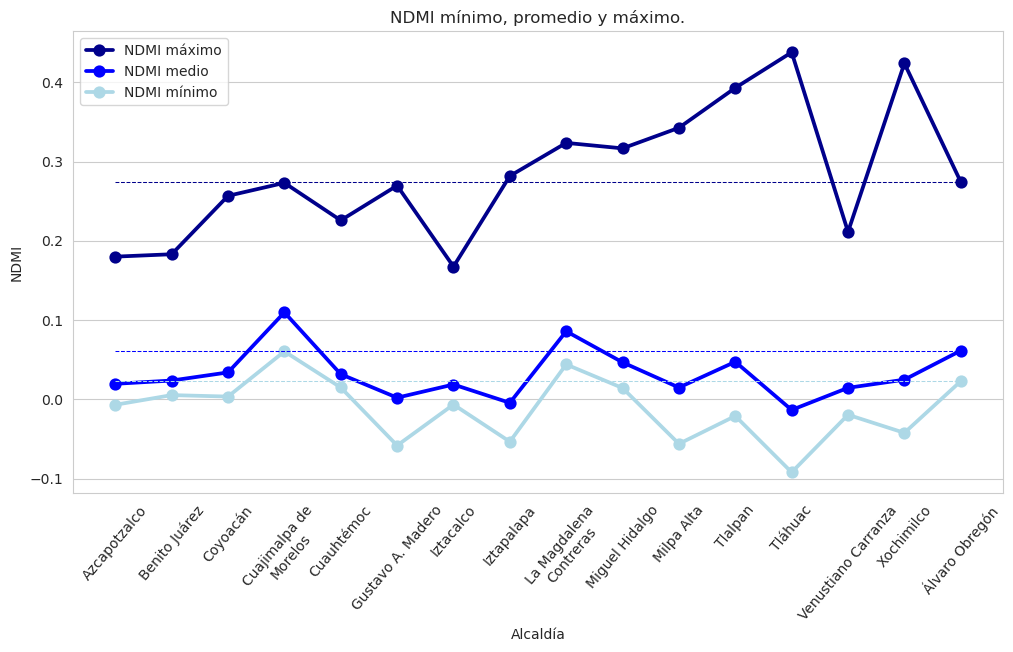

In [108]:
import seaborn as sns
import textwrap

sns.set_style("whitegrid")

def wrap_labels(ax, width, rotation, break_long_words=False):
    labels = []
    for label in ax.get_xticklabels():
        text = label.get_text()
        labels.append(textwrap.fill(text, width=width,
                      break_long_words=break_long_words))
    ax.set_xticklabels(labels, rotation=rotation)

fig,ax = plt.subplots(figsize=(12,6))
# Plot data by alcaldía
sns.pointplot(data=grouped_by.rename(columns={"ndmi_max":'NDMI máximo'}), x="nomgeo", y='NDMI máximo', ax=ax,label="NDMI máximo", color='darkblue')
sns.pointplot(data=grouped_by.rename(columns={"ndmi_mean":'NDMI medio'}), x="nomgeo", y='NDMI medio', ax=ax,label="NDMI medio", color='blue')
sns.pointplot(data=grouped_by.rename(columns={"ndmi_min":'NDMI mínimo'}), x="nomgeo", y='NDMI mínimo', ax=ax,label="NDMI mínimo", color='lightblue')
# Plot Álvaro Obregón continuous data line
ndmi_max_alvaro_obregon = grouped_by.loc[grouped_by.nomgeo=='Álvaro Obregón']['ndmi_max'].unique()[0]
ax.plot(alcaldias, [ndmi_max_alvaro_obregon]*len_alcaldias, '--', linewidth=0.75, color='darkblue')

ndmi_mean_alvaro_obregon = grouped_by.loc[grouped_by.nomgeo=='Álvaro Obregón']['ndmi_mean'].unique()[0]
ax.plot(alcaldias, [ndmi_mean_alvaro_obregon]*len_alcaldias, '--', linewidth=0.75, color='blue')

ndmi_min_alvaro_obregon = grouped_by.loc[grouped_by.nomgeo=='Álvaro Obregón']['ndmi_min'].unique()[0]
ax.plot(alcaldias, [ndmi_min_alvaro_obregon]*len_alcaldias, '--', linewidth=0.75, color='lightblue')

# Format - Legend
ax.legend()

# Format - Titles
ax.set_title(f'NDMI mínimo, promedio y máximo.')
ax.set_xlabel("Alcaldía")
ax.set_ylabel("NDMI")

wrap_labels(ax, 20, 50)